## Subjectlist with temporal imputation using unable data = subjectlist2
GCS의 unable 이 intubation 으로 인해 verbal test 를 못하는 상황에 체크되었다고 가정하고, 이를 이용하여 intubation extubation time 을 추가한다. 이 때 생기는 오류를 정제하여 data reconstruction(temporal imputation)을 한다.

In [ ]:
import pandas as pd
import sys
from pathlib import Path

# 소스코드(src)
import src.data_extraction.filter_adult_patients as fap
import src.data_extraction.filter_ventilation_events as fve

In [ ]:
patients = pd.read_csv('./origin_data/patients.csv')
admissions = pd.read_csv('./origin_data/admissions.csv', parse_dates = ['admittime','dischtime','deathtime','edregtime','edouttime'])
intubation_all = pd.read_csv('./origin_data/intubation_all.csv', parse_dates = ['starttime','endtime','storetime'])
extubation_all = pd.read_csv('./origin_data/extubation_all.csv', parse_dates = ['starttime','endtime','storetime'])
icustays = pd.read_csv('./origin_data/icustays.csv', parse_dates = ['intime','outtime'])

### 1. 데이터 처리
- 1-1. 환자 정보 정제
- 1-2. unable 데이터 찾기
- 1-3. unable 시간으로 intubationtime_un, extubationtime_un 을 생성



#### 1.1. 환자 정보 필터링(선정제외조건)
- 성인 환자 (anchor age >= 18) >>

    - 병원 입원(hadm_id) 정보가 있는 환자 >>
    
        -  중환자실 입원(stay_id) 정보가 있는 환자

In [9]:
## 데이터 처리: 응급병동? 환자 데이터 (filter_adult_patients)
# 성인환자 데이터 필터링(선정제외조건)
adults_pat = fap.filter_adult_patients(patients)   # 18세 이상 필터링
adults_hadm = fap.merge_patient_admissions(adults_pat, admissions)   # patient, admissions 테이블 결합
adults_hadm = fap.remove_missing_hadm(adults_hadm)   # 입원정보(hadm_id) 없는 행 삭제
adults_icu = fap.merge_with_icu(adults_hadm, icustays)   # icu (응급병동?) 테이블 결합
adults_icu = fap.remove_missing_icu_stays(adults_icu)   # icu 입원정보(stay_id) 없는 행 삭제

print(f'Processed adults_icu: {adults_icu.shape}')   # (73181, 13)
print(adults_icu.columns)

Number of adult patients retrieved: 299712
Processed adults_icu: (73181, 13)
Index(['subject_id', 'gender', 'anchor_age', 'hadm_id', 'admittime',
       'dischtime', 'deathtime', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los'],
      dtype='object')


In [10]:
# 데이터 요약
adult_hadm_count = adults_hadm.subject_id.nunique()
adults_icu_count = adults_icu.subject_id.nunique()

print(f'adult patients with hospital admission history: {adult_hadm_count}')
print(f'adult patients with ICU history: {adults_icu_count}')

adult patients with hospital admission history: 180733
adult patients with ICU history: 50920


In [11]:
## 데이터 처리: 삽관/발관 데이터 (filter_ventilation_events)
# 삽관/발관 데이터 필터링 및 처리
intubation_data = fve.filter_and_label_ventilation_data(intubation_all, 'intubationtime', 'intubation')
extubation_data = fve.filter_and_label_ventilation_data(extubation_all, 'extubationtime', 'extubation')

# 삽관 발관 테이블 결합
intubation_extubation = fve.join_ventilation_and_rename_stay_id(intubation_data, extubation_data)

# 입원 데이터 결합
intubation_extubation = fve.join_admissions_stayid(intubation_extubation, admissions)

print(f'Processed intubation_extubation: {intubation_extubation.shape}')   # (10668, 13)
print(intubation_extubation.columns)

print(f'intubation_data: {intubation_data.shape}')
print(f'extubation_data: {extubation_data.shape}')

Processed intubation_extubation: (10668, 13)
Index(['subject_id', 'hadm_id', 'stay_id', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'extubationtime', 'ext_itemid',
       'ext_weight', 'extubationcause', 'dischtime', 'deathtime'],
      dtype='object')
intubation_data: (8488, 6)
extubation_data: (23122, 7)


In [ ]:
adults_icu.to_csv('./data/adults_icu.csv', index=True)
intubation_extubation.to_csv('./data/intubation_extubation_before_unable.csv', index=True)

#### 1.2.Unable 데이터 구성

1.2.1. intubation_extubation_data 불러와서 subjectlist 생성

In [13]:
# 이미 생성된 intubation_extubation 파일 불러오기
subjectlist = pd.read_csv('./data/intubation_extubation_before_unable.csv', parse_dates=['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime'], index_col=0)

# 데이터 확인
print(f"Loaded subjectlist shape: {subjectlist.shape}")
print(subjectlist.columns)
print(subjectlist.head())
print(subjectlist.info())

# 필요한 경우 subjectlist를 저장
subjectlist.to_csv('./data/subjectlist_before_unable.csv', index=True)

Loaded subjectlist shape: (10668, 13)
Index(['subject_id', 'hadm_id', 'stay_id', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'extubationtime', 'ext_itemid',
       'ext_weight', 'extubationcause', 'dischtime', 'deathtime'],
      dtype='object')
   subject_id   hadm_id   stay_id           admittime      intubationtime  \
0    10001884  26184834  37510196 2131-01-07 20:39:00 2131-01-11 04:30:00   
1    10003400  23559586  38383343 2137-08-04 00:07:00 2137-08-17 21:21:00   
2    10004401  27939719  31202136 2144-04-11 03:31:00 2144-04-11 05:03:00   
3    10004401  29988601  32773003 2144-01-23 07:58:00 2144-01-27 19:00:00   
4    10004401  29988601  32773003 2144-01-23 07:58:00 2144-01-30 13:00:00   

   int_itemid  int_weight      extubationtime  ext_itemid  ext_weight  \
0      224385        65.0 2131-01-12 17:40:00    227194.0        65.0   
1      224385        90.5 2137-08-21 15:40:00    227194.0        99.6   
2      224385       120.0                 NaT     

In [14]:
subjectlist.head(5)

,subject_id,hadm_id,stay_id,admittime,intubationtime,int_itemid,int_weight,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-11 04:30:00,224385,65.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-08-17 21:21:00,224385,90.5,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-11 05:03:00,224385,120.0,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-01-27 19:00:00,224385,76.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-01-30 13:00:00,224385,76.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT


In [ ]:
# 파일 읽기
sub_gcs_me = pd.read_csv('./origin_data/sub_gcs_me.csv', encoding='utf-8-sig', index_col=0, parse_dates=['charttime'])

# 각 데이터프레임의 기본 정보 출력
for name, df in [
                 ('sub_gcs_notna', sub_gcs_me), 
                 ('icustays', icustays)]:
    print(f"\n{name} shape: {df.shape}")
    print(f"{name} columns: {df.columns.tolist()}")
    print(f"{name} first few rows:")
    print(df.head())
    print("-" * 50)


sub_gcs_notna shape: (821289, 11)
sub_gcs_notna columns: ['subject_id', 'hadm_id', 'int_stayid', 'stay_id', 'charttime', 'gcs', 'gcs_motor', 'gcs_verbal', 'gcs_eyes', 'gcs_unable', 'gcs_m_e']
sub_gcs_notna first few rows:
            subject_id   hadm_id  int_stayid   stay_id           charttime  \
Unnamed: 0                                                                   
814152        10001884  26184834    37510196  37510196 2131-01-11 08:00:00   
814153        10001884  26184834    37510196  37510196 2131-01-11 10:00:00   
814154        10001884  26184834    37510196  37510196 2131-01-11 12:00:00   
814155        10001884  26184834    37510196  37510196 2131-01-11 14:00:00   
814156        10001884  26184834    37510196  37510196 2131-01-11 16:00:00   

             gcs  gcs_motor  gcs_verbal  gcs_eyes  gcs_unable  gcs_m_e  
Unnamed: 0                                                              
814152      15.0        1.0         0.0       1.0         1.0      2.0  
814153     

#### 1.3 unable 시간으로 intubationtime(un), extubationtime(un) 을 생성

<class 'pandas.core.frame.DataFrame'>
Index: 821289 entries, 814152 to 811734
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   subject_id  821289 non-null  int64         
 1   hadm_id     821289 non-null  int64         
 2   int_stayid  821289 non-null  int64         
 3   stay_id     821289 non-null  int64         
 4   charttime   821289 non-null  datetime64[ns]
 5   gcs         821289 non-null  float64       
 6   gcs_motor   818854 non-null  float64       
 7   gcs_verbal  819601 non-null  float64       
 8   gcs_eyes    820463 non-null  float64       
 9   gcs_unable  821289 non-null  float64       
 10  gcs_m_e     818207 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 75.2 MB
None
         subject_id       hadm_id    int_stayid       stay_id  \
count  8.212890e+05  8.212890e+05  8.212890e+05  8.212890e+05   
mean   1.504750e+07  2.503301e+07  3.498039e+07

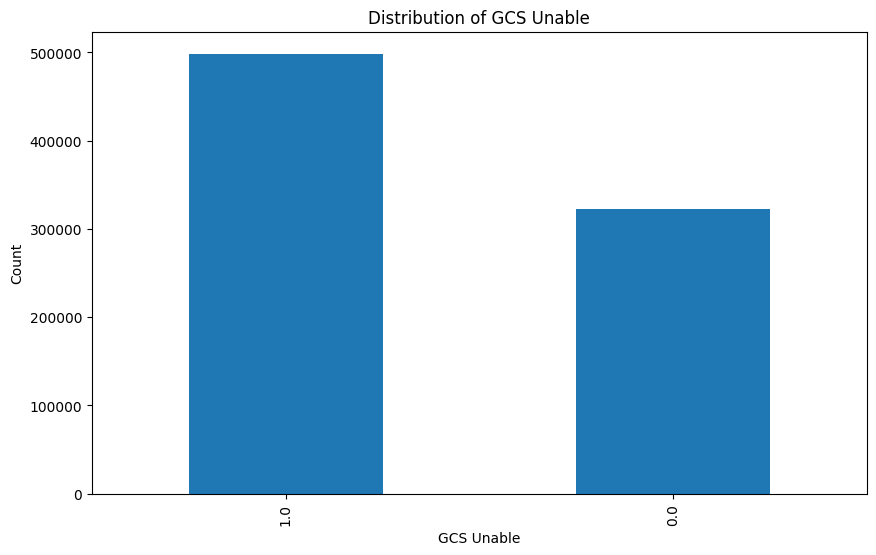

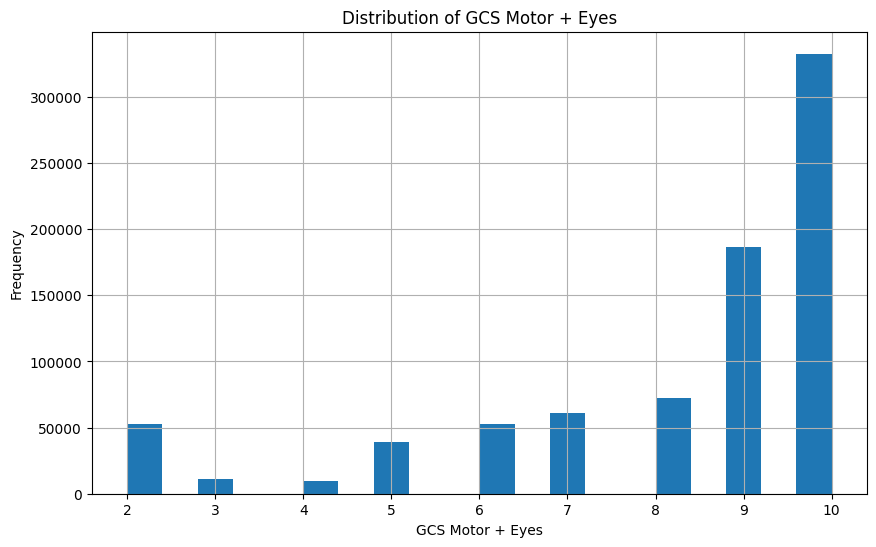

In [16]:
# sub_gcs_me.csv 생성 후 바로 아래에 추가
print(sub_gcs_me.info())
print(sub_gcs_me.describe())

# gcs_unable의 분포 확인
unable_counts = sub_gcs_me['gcs_unable'].value_counts()
print("GCS Unable Distribution:")
print(unable_counts)

import matplotlib.pyplot as plt

# gcs_unable의 분포 시각화
plt.figure(figsize=(10, 6))
unable_counts.plot(kind='bar')
plt.title('Distribution of GCS Unable')
plt.xlabel('GCS Unable')
plt.ylabel('Count')
plt.show()

# gcs_m_e의 분포 시각화
plt.figure(figsize=(10, 6))
sub_gcs_me['gcs_m_e'].hist(bins=20)
plt.title('Distribution of GCS Motor + Eyes')
plt.xlabel('GCS Motor + Eyes')
plt.ylabel('Frequency')
plt.show()

#### unablestarttime, stoptime, seq 컬럼추가 (unabletime 생성위함)
- unablestarttime: unable이 1로 전환된 시점 -> intubationtime(un)으로 컬럼 이름 변경
- unablestoptime: unable이 0으로 전환되기 전 시점 -> extubationtime(un)으로 컬럼 이름 변경
- unableseq: stay_id 기준으로 순서 부여

In [17]:
def find_unable_periods(df):
    results = []

    # subject_id, hadm_id, stay_id 그룹화
    grouped = df.sort_values(['subject_id', 'hadm_id', 'stay_id', 'charttime']).groupby(['subject_id', 'hadm_id'])

    for (subject_id, hadm_id), group in grouped:
        # stay_id로 짜르기
        stay_grouped = group.groupby('stay_id')
        
        for stay_id, stay_group in stay_grouped:
            stay_group = stay_group.sort_values('charttime') 
            unablestarttime = None
            unableseq = 0

            for i in range(len(stay_group)):
                # gcs_unable이 1이 되었을 때의 시간
                if stay_group.iloc[i]['gcs_unable'] == 1 and (i == 0 or stay_group.iloc[i - 1]['gcs_unable'] == 0):
                    unablestarttime = stay_group.iloc[i]['charttime']
                    unableseq += 1

                # gcs_unable이 0이 되었을 때의 시간 
                elif stay_group.iloc[i]['gcs_unable'] == 0 and (i > 0 and stay_group.iloc[i - 1]['gcs_unable'] == 1):
                    unablestoptime = stay_group.iloc[i - 1]['charttime']
                    results.append({
                        'subject_id': subject_id,
                        'hadm_id': hadm_id,
                        'stay_id': stay_id,
                        'intubationtime(un)': unablestarttime,
                        'extubationtime(un)': unablestoptime,
                        'unableseq': unableseq
                    })
                    unablestarttime = None

            # 마지막까지 unable이 1인 경우 마지막을 extubationtime(un)으로
            if stay_group.iloc[-1]['gcs_unable'] == 1 and unablestarttime is not None:
                unablestoptime = stay_group.iloc[-1]['charttime']
                results.append({
                    'subject_id': subject_id,
                    'hadm_id': hadm_id,
                    'stay_id': stay_id,
                    'intubationtime(un)': unablestarttime,
                    'extubationtime(un)': unablestoptime,
                    'unableseq': unableseq
                })
    
    return pd.DataFrame(results)


result_df = find_unable_periods(sub_gcs_me)
result_df

,subject_id,hadm_id,stay_id,intubationtime(un),extubationtime(un),unableseq
0,10001884,26184834,37510196,2131-01-11 08:00:00,2131-01-12 17:30:00,1
1,10001884,26184834,37510196,2131-01-13 04:00:00,2131-01-13 20:00:00,2
2,10001884,26184834,37510196,2131-01-14 08:08:00,2131-01-17 20:09:00,3
3,10001884,26184834,37510196,2131-01-19 00:00:00,2131-01-19 08:00:00,4
4,10003400,23559586,38383343,2137-08-18 02:00:00,2137-08-21 16:00:00,1
...,...,...,...,...,...,...
17635,19999068,21606769,30143796,2161-08-25 17:13:00,2161-08-27 04:56:00,1
17636,19999068,21606769,30143796,2161-08-27 19:30:00,2161-08-28 12:38:00,2
17637,19999442,26785317,32336619,2148-11-19 23:00:00,2148-11-20 13:00:00,1
17638,19999840,21033226,38978960,2164-09-12 10:11:00,2164-09-12 16:00:00,1


In [18]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17640 entries, 0 to 17639
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   subject_id          17640 non-null  int64         
 1   hadm_id             17640 non-null  int64         
 2   stay_id             17640 non-null  int64         
 3   intubationtime(un)  17640 non-null  datetime64[ns]
 4   extubationtime(un)  17640 non-null  datetime64[ns]
 5   unableseq           17640 non-null  int64         
dtypes: datetime64[ns](2), int64(4)
memory usage: 827.0 KB


In [19]:
result_df.to_csv('./data/unable_periods.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17640 entries, 0 to 17639
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   subject_id          17640 non-null  int64         
 1   hadm_id             17640 non-null  int64         
 2   stay_id             17640 non-null  int64         
 3   intubationtime(un)  17640 non-null  datetime64[ns]
 4   extubationtime(un)  17640 non-null  datetime64[ns]
 5   unableseq           17640 non-null  int64         
dtypes: datetime64[ns](2), int64(4)
memory usage: 827.0 KB
None
         subject_id       hadm_id       stay_id  \
count  1.764000e+04  1.764000e+04  1.764000e+04   
mean   1.508611e+07  2.507131e+07  3.496863e+07   
min    1.000188e+07  2.000136e+07  3.000115e+07   
25%    1.272125e+07  2.249772e+07  3.246012e+07   
50%    1.514923e+07  2.518118e+07  3.494151e+07   
75%    1.752190e+07  2.757398e+07  3.746081e+07   
max    1.999984e+07  2.

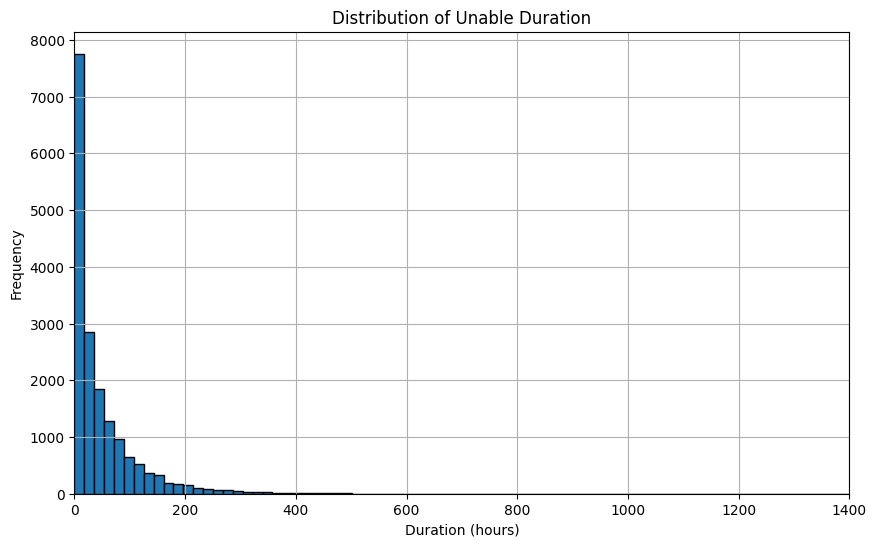

count    17640.000000
mean        48.274604
std         93.561160
min          0.000000
25%          7.733333
50%         23.416667
75%         63.937500
max       8944.000000
Name: unable_duration, dtype: float64



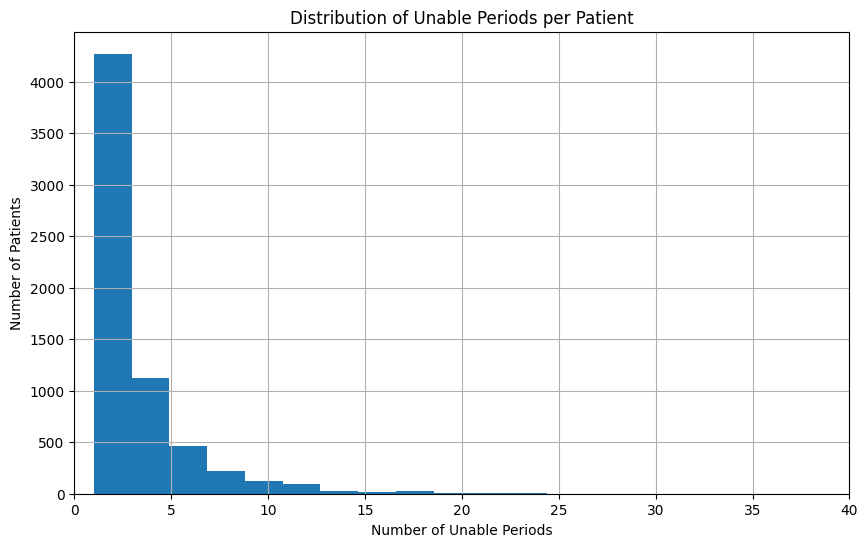

In [20]:
# find_unable_periods 함수 실행 후 바로 아래에 추가
print(result_df.info())
print(result_df.describe())

# unable 기간의 분포 시각화
result_df['unable_duration'] = (result_df['extubationtime(un)'] - result_df['intubationtime(un)']).dt.total_seconds() / 3600  # 시간 단위로 변환

plt.figure(figsize=(10, 6))
result_df['unable_duration'].hist(bins=500, edgecolor = 'k')
plt.title('Distribution of Unable Duration')
plt.xlabel('Duration (hours)')
# plt.xlim([0, result_df['unable_duration'].max()])
plt.xlim([0,1400])
plt.ylabel('Frequency')
plt.show()

print(result_df['unable_duration'].describe())
print()

# 환자별 unable 횟수 분포
patient_unable_counts = result_df.groupby('subject_id').size()
plt.figure(figsize=(10, 6))
patient_unable_counts.hist(bins=20)
plt.title('Distribution of Unable Periods per Patient')
plt.xlabel('Number of Unable Periods')
plt.xlim([0, patient_unable_counts.max()])
plt.ylabel('Number of Patients')
plt.show()

- 데이터를 더 잘 파악하기 위해 gender, 등 인구학적 컬럼 추가

In [ ]:
# 기존 데이터 로드
result_df = pd.read_csv('./data/unable_periods.csv', parse_dates = ['intubationtime(un)','extubationtime(un)'])

# 환자 정보 로드
patients = pd.read_csv('./origin_data/patients.csv')
admissions = pd.read_csv('./origin_data/admissions.csv', parse_dates = ['admittime','dischtime','deathtime','edregtime','edouttime'])
icustays = pd.read_csv('./origin_data/icustays.csv', parse_dates=['intime', 'outtime'])

# 필요한 정보만 선택
patients = patients[['subject_id', 'gender']]
admissions = admissions[['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime']]
icustays = icustays[['subject_id', 'hadm_id', 'stay_id', 'los']]

# 데이터 병합
result_df = (result_df
             .merge(patients, on='subject_id', how='left')
             .merge(admissions, on=['subject_id', 'hadm_id'], how='left')
             .merge(icustays, on=['subject_id', 'hadm_id', 'stay_id'], how='left'))

# 결과 저장
result_df.to_csv('./data/unable_periods_enriched.csv', index=False)

print("Enriched data saved to 'unable_periods_enriched.csv'")

Enriched data saved to 'unable_periods_enriched.csv'


#### intu_extu_duration(period) 컬럼 추가
- extubationtime(un) - intubationtime(un)

In [22]:
result_df['intu_extu_duration(period)'] = (result_df['extubationtime(un)'] - result_df['intubationtime(un)']).dt.total_seconds() / 3600 # hour 단위

#### to_reintubation(un) 컬럼 추가
- 시퀀스 내의 기준으로, n+1행의 intubationtime(un)에서 n행의 extubationtime(un)을 빼서 구함

In [23]:
# 다음 intubationtime 행 가져오기
result_df['next_intubationtime'] = result_df.groupby(['subject_id', 'hadm_id', 'stay_id'])['intubationtime(un)'].shift(-1)

# extubation과 다음 intubation 사이의 시간 계산
result_df['to_reintubation(un)'] = (result_df['next_intubationtime'] - result_df['extubationtime(un)']).dt.total_seconds() / 3600

# NULL을 0으로
result_df['to_reintubation(un)'] = result_df['to_reintubation(un)'].fillna(0)

# 불필요 컬럼 삭제
result_df = result_df.drop(columns=['next_intubationtime'])
result_df

,Unnamed: 0,subject_id,hadm_id,stay_id,intubationtime(un),extubationtime(un),unableseq,gender,admittime,dischtime,deathtime,los,intu_extu_duration(period),to_reintubation(un)
0,0,10001884,26184834,37510196,2131-01-11 08:00:00,2131-01-12 17:30:00,1,F,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,9.171817,33.500000,10.500000
1,1,10001884,26184834,37510196,2131-01-13 04:00:00,2131-01-13 20:00:00,2,F,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,9.171817,16.000000,12.133333
2,2,10001884,26184834,37510196,2131-01-14 08:08:00,2131-01-17 20:09:00,3,F,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,9.171817,84.016667,27.850000
3,3,10001884,26184834,37510196,2131-01-19 00:00:00,2131-01-19 08:00:00,4,F,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,9.171817,8.000000,0.000000
4,4,10003400,23559586,38383343,2137-08-18 02:00:00,2137-08-21 16:00:00,1,F,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,16.069838,86.000000,82.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17635,17635,19999068,21606769,30143796,2161-08-25 17:13:00,2161-08-27 04:56:00,1,M,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,6.765324,35.716667,14.566667
17636,17636,19999068,21606769,30143796,2161-08-27 19:30:00,2161-08-28 12:38:00,2,M,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,6.765324,17.133333,0.000000
17637,17637,19999442,26785317,32336619,2148-11-19 23:00:00,2148-11-20 13:00:00,1,M,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,6.950370,14.000000,0.000000
17638,17638,19999840,21033226,38978960,2164-09-12 10:11:00,2164-09-12 16:00:00,1,M,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,5.297766,5.816667,12.083333


##### 가독성위해 컬럼 순서 변경

In [24]:
columns=['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'admittime', 'intubationtime(un)',\
          'extubationtime(un)', 'intu_extu_duration(period)', 'to_reintubation(un)', 'unableseq', 'dischtime', 'deathtime']
result_df = result_df[columns]
result_df

,subject_id,hadm_id,stay_id,gender,los,admittime,intubationtime(un),extubationtime(un),intu_extu_duration(period),to_reintubation(un),unableseq,dischtime,deathtime
0,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-11 08:00:00,2131-01-12 17:30:00,33.500000,10.500000,1,2131-01-20 05:15:00,2131-01-20 05:15:00
1,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-13 04:00:00,2131-01-13 20:00:00,16.000000,12.133333,2,2131-01-20 05:15:00,2131-01-20 05:15:00
2,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-14 08:08:00,2131-01-17 20:09:00,84.016667,27.850000,3,2131-01-20 05:15:00,2131-01-20 05:15:00
3,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-19 00:00:00,2131-01-19 08:00:00,8.000000,0.000000,4,2131-01-20 05:15:00,2131-01-20 05:15:00
4,10003400,23559586,38383343,F,16.069838,2137-08-04 00:07:00,2137-08-18 02:00:00,2137-08-21 16:00:00,86.000000,82.000000,1,2137-09-02 17:05:00,2137-09-02 17:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17635,19999068,21606769,30143796,M,6.765324,2161-08-24 04:10:00,2161-08-25 17:13:00,2161-08-27 04:56:00,35.716667,14.566667,1,2161-09-02 19:00:00,NaT
17636,19999068,21606769,30143796,M,6.765324,2161-08-24 04:10:00,2161-08-27 19:30:00,2161-08-28 12:38:00,17.133333,0.000000,2,2161-09-02 19:00:00,NaT
17637,19999442,26785317,32336619,M,6.950370,2148-11-19 10:00:00,2148-11-19 23:00:00,2148-11-20 13:00:00,14.000000,0.000000,1,2148-12-04 16:25:00,NaT
17638,19999840,21033226,38978960,M,5.297766,2164-09-10 13:47:00,2164-09-12 10:11:00,2164-09-12 16:00:00,5.816667,12.083333,1,2164-09-17 13:42:00,2164-09-17 13:42:00


In [25]:
result_df.to_csv('./data/unable_intu_extu.csv', index=False, encoding='utf-8-sig')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17640 entries, 0 to 17639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   subject_id                  17640 non-null  int64         
 1   hadm_id                     17640 non-null  int64         
 2   stay_id                     17640 non-null  int64         
 3   gender                      17640 non-null  object        
 4   los                         17640 non-null  float64       
 5   admittime                   17640 non-null  datetime64[ns]
 6   intubationtime(un)          17640 non-null  datetime64[ns]
 7   extubationtime(un)          17640 non-null  datetime64[ns]
 8   intu_extu_duration(period)  17640 non-null  float64       
 9   to_reintubation(un)         17640 non-null  float64       
 10  unableseq                   17640 non-null  int64         
 11  dischtime                   17640 non-null  datetime64

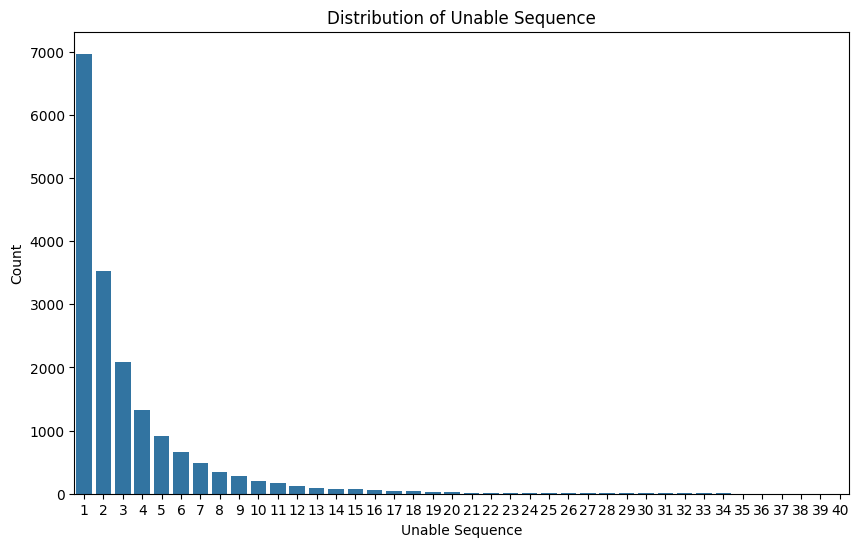

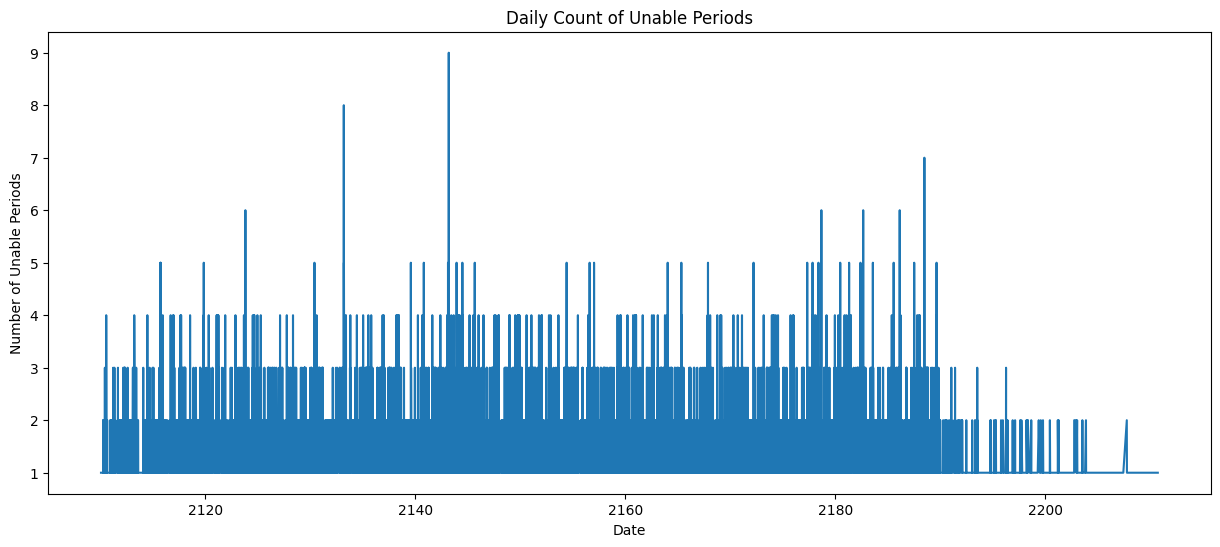

In [26]:
import seaborn as sns

# CSV 파일 읽기
unable_intu_extu = pd.read_csv('./data/unable_intu_extu.csv', 
                               encoding='utf-8-sig', parse_dates = ['admittime','intubationtime(un)','extubationtime(un)','dischtime','deathtime'])

# 데이터 기본 정보 확인
print(unable_intu_extu.info())
print(unable_intu_extu.describe())

# 상위 10명의 환자 unable 횟수
print("Top 10 patients with most unable periods:")
print(patient_unable_counts.nlargest(10))

# unableseq 분포
plt.figure(figsize=(10, 6))
sns.countplot(x='unableseq', data=unable_intu_extu)
plt.title('Distribution of Unable Sequence')
plt.xlabel('Unable Sequence')
plt.ylabel('Count')
plt.show()

# 시간에 따른 unable 발생 추이
unable_intu_extu['intubation_date'] = unable_intu_extu['intubationtime(un)'].dt.date
daily_unable_count = unable_intu_extu.groupby('intubation_date').size()

plt.figure(figsize=(15, 6))
daily_unable_count.plot()
plt.title('Daily Count of Unable Periods')
plt.xlabel('Date')
plt.ylabel('Number of Unable Periods')
plt.show()

##### 3. before_reconstruction 테이블 구성

In [27]:
import time
from tqdm import tqdm
import warnings
import src_unable.pairing as pairing # 삽관 발관 페어링 관련 모듈
import src_unable.reintubation as rnt  # 재삽관 시간 계산 관련 모듈
import src_unable.subject_classification as cls  
import src.utils.utils as util   # 기타 유틸리티 모듈
import src.data_extraction.filter_ventilation_events as fve

##### 3-1. 데이터 불러오기

In [ ]:
adults_icu = pd.read_csv('./data/adults_icu.csv', parse_dates=['admittime', 'dischtime', 'deathtime'])
intubation_extubation = pd.read_csv('./data/intubation_extubation_before_unable.csv', parse_dates=['intubationtime', 'extubationtime','admittime', 'dischtime', 'deathtime'])

In [33]:
# 성인 환자 데이터와 삽관 발관 데이터 결합
adults_icu_filtered = adults_icu.drop(columns=['admittime', 'dischtime', 'deathtime'])
joined_df = pd.merge(intubation_extubation, adults_icu_filtered, on=['subject_id', 'hadm_id','stay_id'], how='inner')

# 칼럼 순서 변경
final_columns = ['subject_id', 'hadm_id', 'stay_id','gender', 'los', 'admittime', 'intubationtime',
                 'int_itemid', 'int_weight','extubationtime',
                 'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime',
                 'deathtime']

joined_df = joined_df[final_columns]
joined_df.head()

,subject_id,hadm_id,stay_id,gender,los,admittime,intubationtime,int_itemid,int_weight,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime
0,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-11 04:30:00,224385,65.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00
1,10003400,23559586,38383343,F,16.069838,2137-08-04 00:07:00,2137-08-17 21:21:00,224385,90.5,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00
2,10004401,27939719,31202136,M,2.523519,2144-04-11 03:31:00,2144-04-11 05:03:00,224385,120.0,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT
3,10004401,29988601,32773003,M,10.636238,2144-01-23 07:58:00,2144-01-27 19:00:00,224385,76.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT
4,10004401,29988601,32773003,M,10.636238,2144-01-23 07:58:00,2144-01-30 13:00:00,224385,76.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT


##### 3-2. intubation_extubation 페어링

In [34]:
def pair_data(df):
    start_time = time.time()   # 소요시간 계산

    # subject_id와 stay_id, hadm_id로 그룹화
    # 수정
    grouped_df = df.groupby(['subject_id', 'hadm_id','stay_id'])

    single_row_list = []
    reformatted_paired_dataframe_list = []

    # 데이터 1차 정리: single row processing, multirow pairing & reformatting
    for (subject_id, hadm_id, stay_id), group in tqdm(grouped_df, desc="Pairing data..."):
     

        # single row processing
        # 해당 그룹(hadm_id)에 intubation 이벤트가 하나만 있는 경우 (즉, 페어링이 필요 없는 경우)
        if group['intubationtime'].count() == 1:
            # inttime, exttime 만 검증 후 데이터 통과
            # time_mismatch = pairing.validate_single_rows(group)   # True 일 경우 통과. False일 경우 삭제
            # if not time_mismatch:
            single_row_list.append(group)   # bypass single row event
    

        # 해당 그룹(hadm_id) 안에 여러 개의 intubation 이벤트가 있는 경우 (즉, 페어링이 필요한 경우)
        elif group['intubationtime'].count() > 1:
            # (subject_id, hadm_id) 그룹 내에서 고유한 intubationtime, extubationtime 값 추출
            unique_intubations = list(group['intubationtime'].dropna().unique())
            unique_extubations = list(group['extubationtime'].dropna().unique())

            pairs = pairing.main_pairing(unique_intubations, unique_extubations)   # 페어링 함수 적용

            # 페어링 완료 후 데이터 재구조화 (필요한 칼럼 가져오기)
            reformatted_paired_dataframe = pairing.reformat_paired_data_to_dataframe(group, pairs, subject_id, hadm_id, stay_id) # 수정
            reformatted_paired_dataframe['gender'] = group['gender'].iloc[0] 
            # reformatted_paired_dataframe['stay_id'] = group['stay_id'].iloc[0]
            reformatted_paired_dataframe_list.append(reformatted_paired_dataframe)
    

    # 데이터프레임 결합하기
    combined_list = single_row_list + reformatted_paired_dataframe_list

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        combined_df = pd.concat(combined_list, ignore_index=True)

    # 'subject_id', 'hadm_id', 'imputationtime' 순으로 정렬 (ascending=True)
    combined_df = combined_df.sort_values(by=['subject_id', 'hadm_id', 'intubationtime', 'extubationtime'], ascending=True)
    combined_df = combined_df.reset_index(drop=True)

    # 각 그룹별로 시퀀스 넘버링 해주기
    combined_df['seq_num'] = combined_df.groupby(['subject_id', 'hadm_id']).cumcount() + 1

    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
    print(len(single_row_list))


    return combined_df

In [35]:
paired_df = pair_data(joined_df)


print(f'Processed paired_df: {paired_df.shape}')   # (9405, 17)
paired_df.columns

Pairing data...: 100%|██████████| 7330/7330 [00:07<00:00, 971.04it/s] 


--- RUNTIME: 10.43 seconds ---
5682
Processed paired_df: (9405, 17)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'admittime',
       'intubationtime', 'int_itemid', 'int_weight', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime',
       'marker', 'seq_num'],
      dtype='object')

##### 3-3. reintubation 등 컬럼추가

In [36]:
def get_reintubation(df):
    start_time = time.time()   # 소요시간 계산
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Fetching reintubation data..."):

            patient_df = rnt.create_reintubation_columns(patient_df)   # reintubationtime 칼럼 초기화 (reint_marker, mvtime, 다음 발관 시간, 재삽관 시간)
            patient_df = rnt.sort_ventilation_sequence(patient_df)   # 삽관/발관 시간 페어링
            patient_df = rnt.get_mvtime(patient_df)   # 삽관시간과 발관시간의 차이 계산
            patient_df = rnt.carryover_next_intubationtime(patient_df)   # 다음 삽관시간 가져오기
            patient_df = rnt.get_reint_marker(patient_df)   # 환자별로 재삽관이 존재하는지 마킹 
            patient_df = rnt.get_reintubationtime(patient_df)   # 재삽관 시간 계산하기
            
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)

        # 각 그룹별로 시퀀스 넘버링 해주기
        reintubation_df['seq_num'] = reintubation_df.groupby(['subject_id', 'hadm_id']).cumcount() + 1
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [37]:
reintubation_df = get_reintubation(paired_df)
print(f'Processed reintubation_df: {reintubation_df.shape}')   # (9405, 21)
reintubation_df.columns

Fetching reintubation data...: 100%|██████████| 7087/7087 [00:42<00:00, 166.39it/s]


--- RUNTIME: 44.77 seconds ---
Processed reintubation_df: (9405, 21)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'admittime',
       'intubationtime', 'int_itemid', 'int_weight', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime',
       'marker', 'seq_num', 'reint_marker', 'mvtime', 'reintubation_eventtime',
       'reintubationtime'],
      dtype='object')

분류 코드

11 재삽관 없이 발관후 48시간 넘어 퇴원 | nonfailure

121 재삽관 없이 발관후 48시간 이내 사망 X | nonfailure

1221 재삽관 없이 발관후 24시간 이내 사망 | death

1222 재삽관 없이 발관후 24~48시간 이내 사망 | death

211 48시간 이내 재삽관 | failure

212 48시간 너머 재삽관 | nonfailure

221 최종 발관 이후 48시간 넘어 퇴원 | nonfailure

2221 최종 발관 이후 48시간 이내 사망 X | nonfailure

22221 최종 발관 이후 24시간 이내 사망 | death

22222 최종 발관 이후 24~48시간 이내 사망 | death

999 (null case)현발관-다음발관이 48시간 이내 | Failure

998 (null case)현삽관-다음삽관이 48시간 이내 | Failure

9999 (null case) non-failure 판단 불가 | 제거

In [38]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 행별로 케이스 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)

    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

In [39]:
reintubation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9405 entries, 0 to 9404
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   subject_id              9405 non-null   object        
 1   hadm_id                 9405 non-null   object        
 2   stay_id                 9405 non-null   object        
 3   gender                  9405 non-null   object        
 4   los                     7561 non-null   float64       
 5   admittime               9405 non-null   datetime64[ns]
 6   intubationtime          8434 non-null   datetime64[ns]
 7   int_itemid              8434 non-null   float64       
 8   int_weight              8434 non-null   float64       
 9   extubationtime          6899 non-null   datetime64[ns]
 10  ext_itemid              6899 non-null   float64       
 11  ext_weight              6899 non-null   float64       
 12  extubationcause         6899 non-null   object  

In [40]:
intubation_extubation_before_reconstruction = categorize_patients(reintubation_df)
print(f'Processed intubation_extubation_before_reconstruction: {intubation_extubation_before_reconstruction.shape}')   # (9405, 28)
intubation_extubation_before_reconstruction.columns

Categorizing extubation failure vs non-failure...: 100%|██████████| 7087/7087 [00:37<00:00, 191.23it/s]


--- RUNTIME: 40.36 seconds ---
Processed intubation_extubation_before_reconstruction: (9405, 28)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'admittime',
       'intubationtime', 'int_itemid', 'int_weight', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime',
       'marker', 'seq_num', 'reint_marker', 'mvtime', 'reintubation_eventtime',
       'reintubationtime', 'mvtime_state', 'final_event', 'ext_to_death',
       'ext_to_disch', 'disch_to_death', 'class_code', 'class'],
      dtype='object')

#### 3-4. 비논리적 데이터 flag_extu_before_intu 설정

In [41]:
intubation_extubation_before_reconstruction['flag_extu_before_intu'] = (intubation_extubation_before_reconstruction['intubationtime'] > intubation_extubation_before_reconstruction['extubationtime'])
intubation_extubation_before_reconstruction

,subject_id,hadm_id,stay_id,gender,los,admittime,intubationtime,int_itemid,int_weight,extubationtime,...,reintubation_eventtime,reintubationtime,mvtime_state,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,flag_extu_before_intu
0,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,2131-01-12 17:40:00,...,NaN,NaN,False,True,10775.0,10775.0,0.0,11,nonfailure,False
1,10003400,23559586,38383343,F,16.069838,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,2137-08-21 15:40:00,...,NaN,NaN,False,True,17365.0,17365.0,0.0,11,nonfailure,False
2,10004401,27939719,31202136,M,2.523519,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaT,...,NaN,NaN,False,True,NaN,NaN,NaN,9999,None,False
3,10004401,29988601,32773003,M,10.636238,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,2144-01-30 12:30:00,...,2144-01-30 13:00:00,30.0,False,False,NaN,10035.0,NaN,211,failure,False
4,10004401,29988601,32773003,M,NaN,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaT,...,NaN,NaN,False,True,NaN,NaN,NaN,9999,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9400,19997367,20617667,35616526,F,25.337569,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,2126-05-02 16:30:00,...,2126-05-05 18:20:00,4430.0,False,False,NaN,24345.0,NaN,212,nonfailure,False
9401,19997367,20617667,35616526,F,25.337569,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,2126-05-08 17:29:00,...,NaN,NaN,False,True,NaN,15646.0,NaN,221,nonfailure,False
9402,19999068,21606769,30143796,M,6.765324,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,2161-08-28 13:35:00,...,NaN,NaN,False,True,NaN,7525.0,NaN,11,nonfailure,False
9403,19999442,26785317,32336619,M,6.950370,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,2148-11-20 14:15:00,...,NaN,NaN,True,True,NaN,20290.0,NaN,11,nonfailure,False


In [42]:
intubation_extubation_before_reconstruction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9405 entries, 0 to 9404
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   subject_id              9405 non-null   object        
 1   hadm_id                 9405 non-null   object        
 2   stay_id                 9405 non-null   object        
 3   gender                  9405 non-null   object        
 4   los                     7561 non-null   float64       
 5   admittime               9405 non-null   datetime64[ns]
 6   intubationtime          8434 non-null   datetime64[ns]
 7   int_itemid              8434 non-null   float64       
 8   int_weight              8434 non-null   float64       
 9   extubationtime          6899 non-null   datetime64[ns]
 10  ext_itemid              6899 non-null   float64       
 11  ext_weight              6899 non-null   float64       
 12  extubationcause         6899 non-null   object  

In [44]:
intubation_extubation_before_reconstruction.to_csv('./data/intubation_extubation_before_reconstruction.csv', index=False, encoding='utf-8-sig')